## LAB CHALLENGE: Neural Matrix Factorization 
In the previous lecture we have built a recommender system using the Neural Matrix Factorization framework. This framework allowed us to combine the GMF layers with the MLP layers in this way:
$$\phi^{GMF} = \mathbf{p_u}^G\odot \mathbf{q_i}^G$$
$$\phi^{MLP} = a_L(\mathbf{W}_L^T(a_{L-1}(...a_2 (\mathbf{W}_2^T \begin{bmatrix}
\mathbf{p_u} \\ \mathbf{q_i}
\end{bmatrix} + \mathbf{b}_2)...)) + \mathbf{b}_L)$$

$$ y_{ui} = \sigma(\mathbf{h}^T \begin{bmatrix}
\ \phi^{GMF} \\ \phi^{MLP}
\end{bmatrix})$$

<center>  <img src="https://drive.google.com/uc?export=view&id=1gNLUpiQdbDPMdvfZYVs3lcou3cd4Favb" width="550" height="400"> </center> 

Let's now try to apply transfer learning to such an architecture. 

- TASK 1: Train the GMF and MLP models separately, inspect and save the parameters.
- TASK 2: Use the pre-trained parameters for initializing the NMF architecture. In particular, use the pre-trained embeddings for users and items and the initialized layers of GMF and MLP.
- TASK 3: Finally, train the NMF model both by freezing the layers preceding the NeuMF layer and by keeping all the parameters trainable. Compare the performance with the network trained from scratch.


In [39]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

from metrics import metrics
from NCF_Data import NCF_Data

## PATH definition

In [40]:
PATH = "./ml-100k/u.data" 
MODEL_PATH = "./models/" 

## Parameters Definition

In [41]:
args = {
    "seed": 42,
    "lr": 0.01,
    "dropout": 0.0,
    "batch_size": 256,
    "epochs": 30,
    "top_k": 10,
    "num_factors": 8,
    "layers": (64, 32, 16, 8),
    "out": True,
    "num_ng": 4,
    "num_ng_test": 100
}

In [42]:
best_config = {
    "lr": 0.01,
    "batch_size": 128,
    "num_factors_gmf": 16,
    "num_factors_mlp": 64,
    "epochs": 30,
    "out": True,
    "dropout": [0, 0, 0, 0],
}

In [43]:
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

## Load Train and Test loaders

In [44]:
# load data
ml_100k = pd.read_csv(
	PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(ml_100k, args)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# Models

In [45]:
def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, optimizer = None, name_suffix = ""):
    model = model.to(device)

    # Loss and optimizer
    loss_function = nn.BCELoss()
    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=args["lr"])

    best_hr = 0
    
    # Train cycle
    for epoch in range(args["epochs"]):
        start_time = time.time()
        
        # Train step
        model.train()

        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            # Zero grad
            optimizer.zero_grad()
            
            # Prediction
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Eval metrics
        model.eval()
        HR, NDCG = metrics(model, test_loader, args["top_k"], device)

        # Print metrics and time elapsed
        elapsed_time = time.time() - start_time
        print(
            "Epoch {:03d}".format(epoch)
            + " time to train: "
            + time.strftime("%H: %M: %S", time.gmtime(elapsed_time))
        )
        print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

        # If best model, save it
        if HR > best_hr:
            best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
            if args["out"]:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(
                    model, "{}{}{}{}.pt".format(MODEL_PATH, model.__class__.__name__, model.num_factors, name_suffix)
                )


## GMF model

In [46]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]

        self.embedding_user = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.num_factors
        )
        self.embedding_item = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.num_factors
        )

        self.affine_output = nn.Linear(in_features=self.num_factors, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()


In [47]:
#gmf_model = GMF(num_users, num_items)
#train_model(gmf_model, train_loader, test_loader)
gmf_model = torch.load(MODEL_PATH + "GMF8.pt", map_location=device)

## MLP model

In [48]:
class MLP(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = args["num_factors"]
        self.layers = args['layers']

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.num_factors)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.num_factors)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

In [49]:
args["lr"] = 0.01
args["dropout"] = 0
args["num_factors"] = 64
args['layers'] = [128, 64, 32, 16, 8]
mlp_model = MLP(args, num_users, num_items)
#train_model(mlp_model, train_loader, test_loader)
#mlp_model = torch.load(MODEL_PATH + "MLP64.pt", map_location=device)

## NeuMF model

In [50]:
class NeuMF(nn.Module):
    def __init__(self, num_factors_gmf, num_factors_mlp, num_users, num_items, dropout = [0, 0, 0, 0]):

        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.dropout = dropout
        self.num_factors_gmf = num_factors_gmf
        self.num_factors_mlp = num_factors_mlp
        self.num_factors = max(num_factors_mlp, num_factors_gmf) #just for saving model name purpose

        # GMF component
        self.gmf_user_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.num_factors_gmf),
            nn.Dropout(p=self.dropout[1]),
        )
        self.gmf_item_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.num_factors_gmf),
            nn.Dropout(p=self.dropout[1]),
        )
        self.gmf_affine = nn.Linear(
            in_features=self.num_factors_gmf, out_features=self.num_factors_gmf, bias=True
        )

        # MLP component
        self.mlp_user_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.num_factors_mlp),
            nn.Dropout(p=self.dropout[2]),
        )
        self.mlp_item_embed = nn.Sequential(
            nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.num_factors_mlp),
            nn.Dropout(p=self.dropout[2]),
        )

        self.mlp_fc = nn.Sequential(
            #We have considered as possible num_factors [8, 16, 32, 64] so this structure word
            nn.Linear(2 * self.num_factors_mlp, self.num_factors_mlp),
            nn.Dropout(p = dropout[3]),
            nn.ReLU(),

            nn.Linear(self.num_factors_mlp, int(self.num_factors_mlp / 2)),
            nn.Dropout(p = dropout[3] / 2),
            nn.ReLU(),

            nn.Linear(int(self.num_factors_mlp / 2), int(self.num_factors_mlp / 4)),  
            nn.Dropout(p = dropout[3] / 4),
            nn.ReLU(),

            nn.Linear(int(self.num_factors_mlp / 4), int(self.num_factors_mlp / 8)),  
            nn.Dropout(p = dropout[3] / 4),
            nn.ReLU()
        )

        # Combine models
        input_dim = self.num_factors_gmf + int(self.num_factors_mlp / 8)
        self.mixing_layers = nn.Sequential(
            nn.Linear(input_dim, int(input_dim / 2)),
            nn.Dropout(p=dropout[0]),
            nn.ReLU(),

            nn.Linear(int(input_dim / 2), int(input_dim / 4)),
            nn.Dropout(p=dropout[0] / 2),
            nn.ReLU(),

            nn.Linear(int(input_dim / 4), 1),
            nn.Sigmoid(),
        )

    def forward(self, user_indices, item_indices):
        # GMF forward
        user_embedding_gmf = self.gmf_user_embed(user_indices)
        item_embedding_gmf = self.gmf_item_embed(item_indices)

        element_product = torch.mul(user_embedding_gmf, item_embedding_gmf)
        ratings_gmf = self.gmf_affine(element_product)

        # MLP forward
        user_embedding_mlp = self.mlp_user_embed(user_indices)
        item_embedding_mlp = self.mlp_item_embed(item_indices)

        vector = torch.cat((user_embedding_mlp, item_embedding_mlp), dim=-1)
        ratings_mlp = self.mlp_fc(vector)

        ratings = torch.cat((ratings_gmf, ratings_mlp), dim=1)
        return self.mixing_layers(ratings).squeeze()

nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)

In [51]:
args['lr'] = 0.01
nmf_model = torch.load(MODEL_PATH + "Assignment 1 - best.pt", map_location=device)
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)
#train_model(nmf_model, train_loader, test_loader)

# Transfer Learning tasks

We noticed that models trained from scratch exhibit the best results with a learning rate of 0.01 while, in a model where pre-trained layer weights are loaded, a lower learning rate is more effective. In our tests, a learning rate of 0.005 seemed accurate.

To obtain the best results, we also retrained from scratch the GMF and MLP models with the best configuration of num factors reported from the previous task (8 and 64, respectively). The performance of these models, with a learning rate of 0.01, improved significantly and is now comparable to that of the NeuMF model.

For the transfer learning task, we decided to load the weights of the GMF and MLP models with the best performance obtained. 

The weights of the GMF transferred layers are:
- user embeddings
- embedded elements 

The weights of the MLP transferred layers are:
- user embeddings
- embedded elements 
- all weights of the 4 hidden layers

In [52]:
def load_gmf_weights(nmf_model, gmf_model, requires_grad=False):
    nmf_layers_names = [name for name, param in nmf_model.named_parameters()]
    gmf_layers_names = [name for name, param in gmf_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the GMF model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[:2], gmf_layers_names)}
    for nmf_layer_name, gmf_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(gmf_model.state_dict()[gmf_layer_name])
    #deactivate grad for the layers that comes from the GMF model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_mlp_weights(nmf_model, mlp_model, requires_grad=False):
    nmf_layers_names = [name for name, param in nmf_model.named_parameters()]
    mlp_layers_names = [name for name, param in mlp_model.named_parameters()]
    #create a dict that has as key the value of the layer in the NMF model and as value the layer in the MLP model
    layers_name_match_dict = {k: v for k, v in zip(nmf_layers_names[4:], mlp_layers_names[:-2])}
    for nmf_layer_name, mlp_layer_name in layers_name_match_dict.items():
        nmf_model.state_dict()[nmf_layer_name].copy_(mlp_model.state_dict()[mlp_layer_name])
    #deactivate grad for the layers that comes from the MLP model
    for name, param in nmf_model.named_parameters():
        if name in layers_name_match_dict.keys():
            param.requires_grad = requires_grad


def load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad = False):
    load_gmf_weights(nmf_model, gmf_model, requires_grad)
    load_mlp_weights(nmf_model, mlp_model, requires_grad)

## Transfer learning keeping the GMF and MLP of NMF layers freezed

In [53]:
args['lr'] = 0.005

In [54]:
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)

In [55]:
list(nmf_model.named_parameters())[0][1]

Parameter containing:
tensor([[ 0.8972, -0.0262,  1.5371,  ...,  0.6654,  1.3222, -1.3388],
        [ 0.2036, -0.0914, -0.7450,  ...,  0.4793,  1.6004, -0.2473],
        [ 0.9502, -0.1930, -1.5638,  ...,  0.8816, -1.8410, -0.6037],
        ...,
        [ 0.3507, -0.5243, -2.4684,  ..., -0.2468,  1.6957, -1.4250],
        [ 2.9947,  0.4095,  1.3146,  ..., -1.0917,  1.2699, -0.4821],
        [ 0.5620,  0.1374, -0.1622,  ...,  0.2887, -1.0072,  0.3710]],
       requires_grad=True)

In [56]:
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=False)

In [57]:
list(nmf_model.named_parameters())[0][1]


Parameter containing:
tensor([[-1.7370,  0.0054,  2.4798,  ...,  0.4667,  0.9585, -1.3056],
        [-0.3225,  0.7764, -0.7333,  ...,  2.1920, -2.2555, -1.5429],
        [-0.5096, -1.2195,  0.0890,  ..., -3.5754,  0.1880, -2.0185],
        ...,
        [ 2.5621,  5.3520, -1.4401,  ...,  3.5860,  2.2998, -1.8568],
        [-1.6503,  4.6527,  0.3155,  ...,  1.4732,  2.6513, -3.2724],
        [-0.6758,  0.8689, -0.8718,  ...,  1.3159,  0.3292, -0.8313]])

In [58]:
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight False
gmf_item_embed.0.weight False
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight False
mlp_item_embed.0.weight False
mlp_fc.0.weight False
mlp_fc.0.bias False
mlp_fc.3.weight False
mlp_fc.3.bias False
mlp_fc.6.weight False
mlp_fc.6.bias False
mlp_fc.9.weight False
mlp_fc.9.bias False
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [59]:
#train_model(nmf_model, train_loader, test_loader, name_suffix="-freezed42")

## Transfer learning letting the GMF and MLP layers of NMF free

In [60]:
gmf_model = torch.load(MODEL_PATH + "GMF8.pt", map_location=device)
mlp_model = torch.load(MODEL_PATH + "MLP64.pt", map_location=device)
nmf_model = NeuMF(gmf_model.num_factors, mlp_model.num_factors, num_users, num_items)
#nmf_model = torch.load(MODEL_PATH + "NeuMF64-freezed.pt", map_location=device)
load_pre_trained_weights(nmf_model, gmf_model, mlp_model, requires_grad=True)
for name, param in nmf_model.named_parameters():
    print(name, param.requires_grad)

gmf_user_embed.0.weight True
gmf_item_embed.0.weight True
gmf_affine.weight True
gmf_affine.bias True
mlp_user_embed.0.weight True
mlp_item_embed.0.weight True
mlp_fc.0.weight True
mlp_fc.0.bias True
mlp_fc.3.weight True
mlp_fc.3.bias True
mlp_fc.6.weight True
mlp_fc.6.bias True
mlp_fc.9.weight True
mlp_fc.9.bias True
mixing_layers.0.weight True
mixing_layers.0.bias True
mixing_layers.3.weight True
mixing_layers.3.bias True
mixing_layers.6.weight True
mixing_layers.6.bias True


In [61]:
#train_model(nmf_model, train_loader, test_loader, name_suffix="-free42")

# Performance comparison

In [64]:
nmf_freezed = torch.load(MODEL_PATH + "NeuMF64-freezed.pt", map_location = device)
gmf_best = torch.load(MODEL_PATH + "GMF8.pt", map_location = device)
mlp_best = torch.load(MODEL_PATH + "MLP64.pt", map_location = device)
nmf_free = torch.load(MODEL_PATH + "NeuMF64-free.pt", map_location = device)
nmf_init = torch.load(MODEL_PATH + "Assignment 1 - best.pt", map_location = device)

nmf_freezed.to(device) 
gmf_best.to(device) 
mlp_best.to(device)
nmf_free.to(device) 
nmf_init.to(device)

HR, NDCG = {}, {}
HR['NeuMF - freezed'], NDCG['NeuMF - freezed'] = metrics(nmf_freezed, test_loader, 10, device)
HR['NeuMF - free'], NDCG['NeuMF - free'] = metrics(nmf_free, test_loader, 10, device)
HR['NeuMF - scratch'], NDCG['NeuMF - scratch'] = metrics(nmf_init, test_loader, 10, device)
HR['GMF'], NDCG['GMF'] = metrics(gmf_best, test_loader, 10, device)
HR['MLP'], NDCG['MLP'] = metrics(mlp_best, test_loader, 10, device)

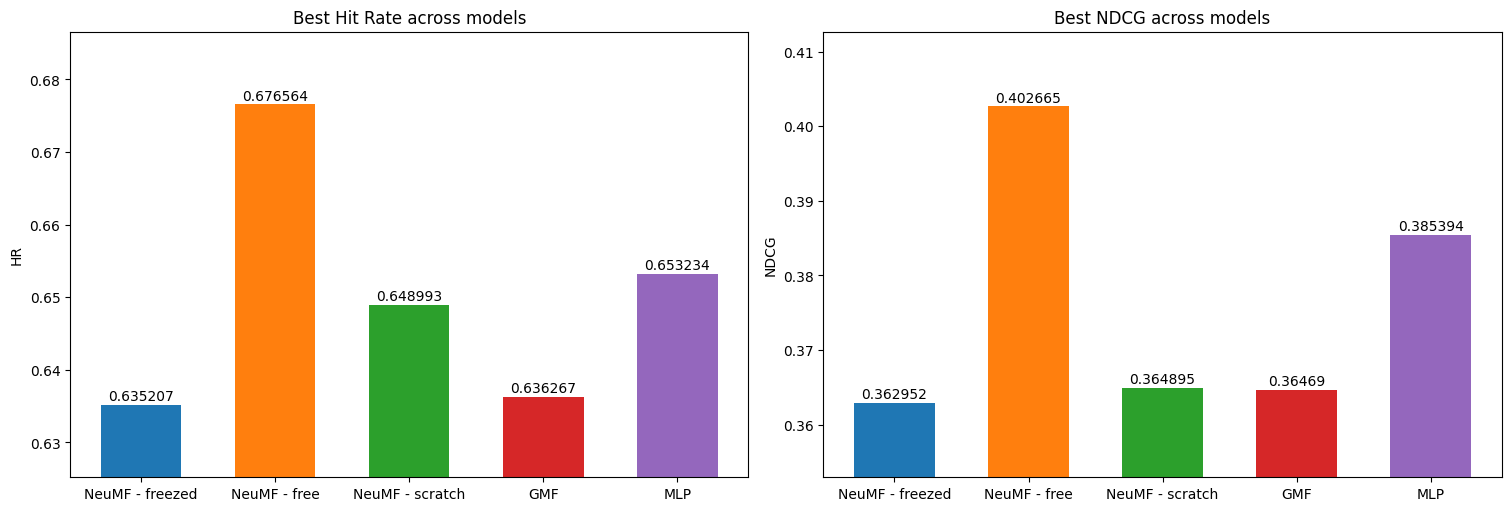

In [65]:
fig, ax = plt.subplots(1, 2, layout = "constrained", figsize = (15, 5))
min_hr, min_ndcg = 1, 1
max_hr, max_ndcg = 0, 0

for model, value in HR.items():
    if value < min_hr:
        min_hr = value
    if value > max_hr:
        max_hr = value
    rect = ax[0].bar(model, value, width= 0.6)
    ax[0].bar_label(rect, padding = 1)

ax[0].set_ylabel("HR")
ax[0].set_ylim(min_hr - 0.01, max_hr + 0.01)
ax[0].set_title("Best Hit Rate across models")

for model, value in NDCG.items():
    if value < min_ndcg:
        min_ndcg = value
    if value > max_ndcg:
        max_ndcg = value
    rect = ax[1].bar(model, value, width= 0.6)
    ax[1].bar_label(rect, padding = 1)

ax[1].set_ylabel("NDCG")
ax[1].set_ylim(min_ndcg - 0.01, max_ndcg + 0.01)
ax[1].set_title("Best NDCG across models")
plt.show()